## Online Shoppers Prediction Using Random Forest and Naive Bayes

In [1]:
#Libraries for Processing
import pandas as pd
import numpy as np
from numpy import mean
import datetime
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

#Libraries for Visualisations
from pylab import plot, show
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#Libraries for Machine learning
#from sklearn.model_selection import StratifiedKFold
#from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#Libraries for Evaluation
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
shoppers = pd.read_csv('dataset/onlineshoppers.csv')

## Exploratory Data Analysis

In [3]:
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
shoppers.shape

(12330, 18)

In [5]:
shoppers.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
shoppers['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

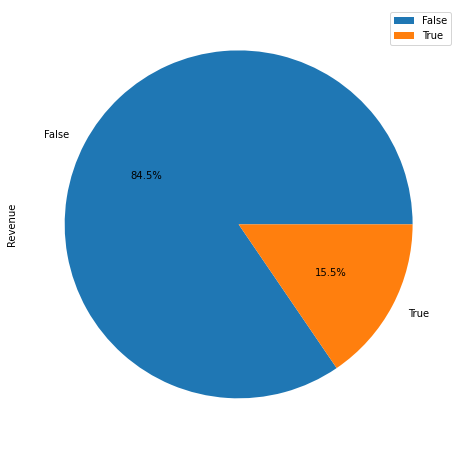

In [7]:
#Pie chart showing the distribution of shoppers revenue in the dataset
shoppers['Revenue'].value_counts().plot(kind = 'pie', 
                                        autopct='%1.1f%%', figsize=(8, 8)).legend(bbox_to_anchor=(1, 1))

### Encoding the Object types columns

In [8]:
shoppers["Month"] = shoppers["Month"].astype('category').cat.codes
shoppers["VisitorType"] = shoppers["VisitorType"].astype('category').cat.codes
shoppers["Weekend"] = shoppers["Weekend"].astype('category').cat.codes
shoppers["Revenue"] = shoppers["Revenue"].astype('category').cat.codes

In [9]:
labels = ["False", "True"]

In [10]:
shoppers['Revenue'].value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

In [11]:
X = shoppers.iloc[:,0:17]

y = shoppers.iloc[:,-1]

### Using RandomOverSampler

In [12]:
# summarize class distribution
print(Counter(y))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

Counter({0: 10422, 1: 1908})
Counter({0: 10422, 1: 10422})


### Data Normalisation

In [13]:
standardScaler = MinMaxScaler()
X_over = standardScaler.fit_transform(X_over)

### Train Test Split

In [14]:
#Use random state (rs) to allow reproduceability
rs = 123

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state = rs)

### Naive Bayes

In [16]:
nb = GaussianNB()
nb = nb.fit(X_train, y_train)
nb

GaussianNB()

In [17]:
y_predNB = nb.predict(X_test)
NBacc=nb.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(NBacc))

Accuracy score= 0.7541


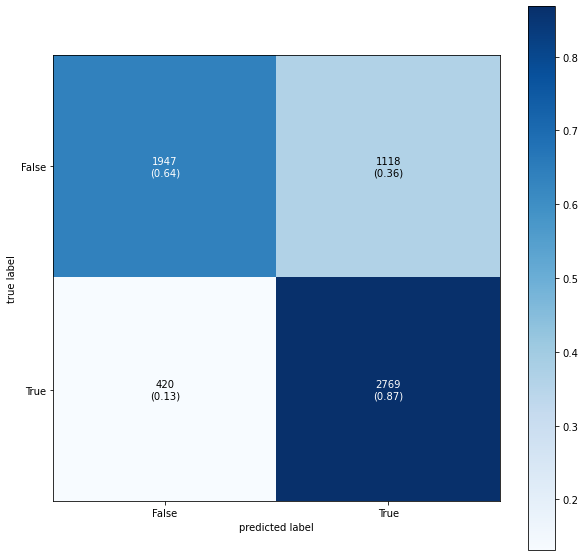

In [18]:
CM=confusion_matrix(y_test, y_predNB)

fig, ax = plot_confusion_matrix(conf_mat=CM,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()

In [19]:
CR=classification_report(y_test, y_predNB, digits=4, target_names= labels)
print(CR)

              precision    recall  f1-score   support

       False     0.8226    0.6352    0.7169      3065
        True     0.7124    0.8683    0.7826      3189

    accuracy                         0.7541      6254
   macro avg     0.7675    0.7518    0.7498      6254
weighted avg     0.7664    0.7541    0.7504      6254



In [20]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predNB)
roc_auc = metrics.auc(fpr, tpr)

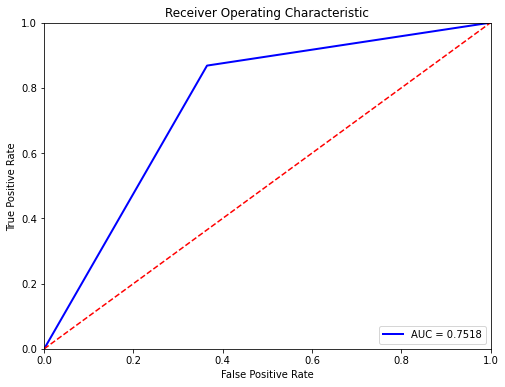

In [21]:
# Plotting ROC Curve
plt.figure(figsize=[8,6])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', linewidth= 2, label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest

In [22]:
rf = RandomForestClassifier(random_state = rs)
rf = rf.fit(X_train, y_train)
rf

RandomForestClassifier(random_state=123)

In [23]:
y_predRF = rf.predict(X_test)
RFacc = rf.score(X_test, y_test)
print('Accuracy score= {:.4f}'.format(RFacc))

Accuracy score= 0.9570


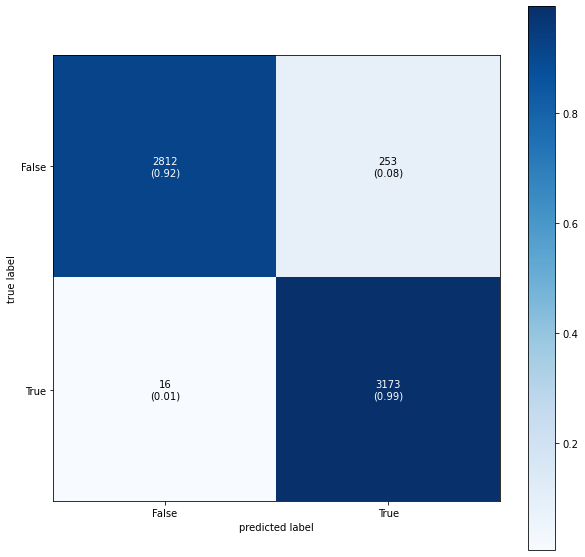

In [24]:
CM=confusion_matrix(y_test, y_predRF)

fig, ax = plot_confusion_matrix(conf_mat=CM,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()

In [25]:
CR=classification_report(y_test, y_predRF, digits=4, target_names= labels)
print(CR)

              precision    recall  f1-score   support

       False     0.9943    0.9175    0.9544      3065
        True     0.9262    0.9950    0.9593      3189

    accuracy                         0.9570      6254
   macro avg     0.9602    0.9562    0.9568      6254
weighted avg     0.9596    0.9570    0.9569      6254



In [26]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predRF)
roc_auc = metrics.auc(fpr, tpr)

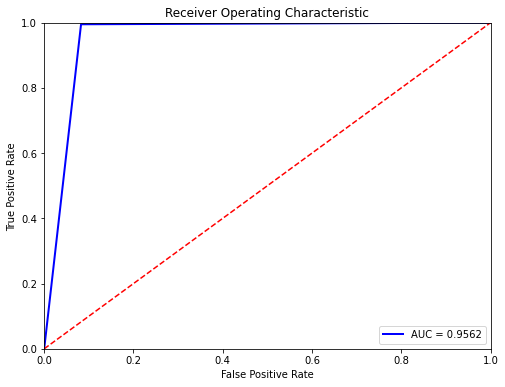

In [27]:
# Plotting ROC Curve
plt.figure(figsize=[8,6])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', linewidth= 2, label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
acc = [NBacc, RFacc]
langs = ['Naive Bayes', 'Random Forest']

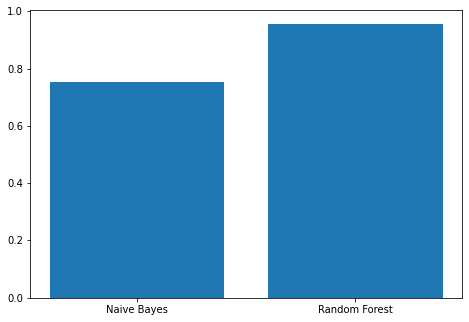

In [29]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.bar(langs,acc)

plt.show()